In [3]:
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pickle
from helpers import load_data, preprocess_data
import csv
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [4]:
path_dataset = "dataset/movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


In [5]:
name_movies=[]
with open('dataset/uitem.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        name_movies.append(row[1])
        #print(row[0],row[1],row[2],)
#name_movies

In [6]:
name_movies1=[]
with open('dataset/uitem1.csv',encoding = "ISO-8859-1") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row1 in readCSV:
        if "*****" in row1[1]:
            #print("YES",row1[1])
            row1[1]=str.replace(row1[1],"*****", ",")
            #print(row1[1])
        name_movies1.append(row1[1]+")")


In [7]:
all_movies=[]
with open('dataset/movies.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        all_movies.append(row)

In [8]:
genre_movies=[]
for i in range(0,1682):
    genre_movies.append("unkwown")

for i in range (0, len(name_movies1)):
    for j in range(1,len( all_movies)):
        if name_movies1[i] in all_movies[j][1]:
            #print(i,all_movies[j][1],"YES",all_movies[j][2])
            genre_movies[i]=(all_movies[j][2])


In [9]:
age_users=[]
gender_users=[]
prof_users=[]
user_info=[]
with open('dataset/uuser.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        age_users.append(row[1])
        if row[2]=="M":
            row[2]="Male"
        elif row[2]=="F":
            row[2]="Female"
        else:
            row[2]="Not specified"
        gender_users.append(row[2])
        prof_users.append(row[3])
        user_info.append(row[1]+", "+row[2]+", "+row[3])
        #print(row[1],row[2],row[3])
        #print(row[0],row[1],row[2],)


In [10]:
prueba=ratings.A
print(prueba.size)
a=np.count_nonzero(prueba) 
print("Rated:",a)
print("Not Rated:",prueba.size-a)

1586126
Rated: 99999
Not Rated: 1486127


### Plot the number of ratings per movie and user

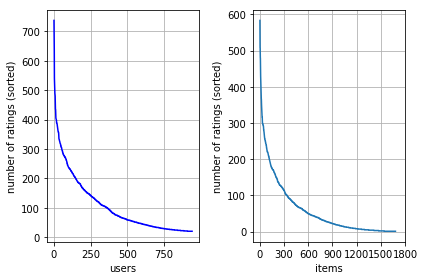

min # of items per user = 20, min # of users per item = 1.


In [11]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)


print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [12]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test, valid_items,valid_users

the shape of original ratings. (# of row, # of col): (1682, 943)
the shape of valid ratings. (# of row, # of col): (603, 568)
Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:66722
Total number of nonzero elements in test data:6821


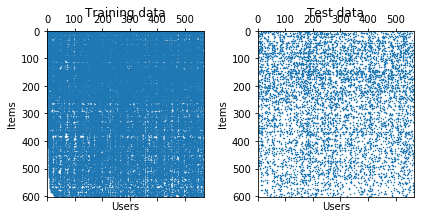

In [13]:
from plots import plot_train_test_data
valid_ratings, train, test, valid_items,valid_users = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=50, p_test=0.1)
plot_train_test_data(train, test)

In [14]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_item, num_user = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [15]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

### Learn the Matrix Factorization using Alternating Least Squares

In [16]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [17]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 10   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
    #Devuelve los indices de los nonzero, para toda la matriz (train), por items
    #print(len(nz_item_userindices))

    # run ALS
    print("\nStart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)
        error = compute_error(train, user_features, item_features, nz_train)
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("RMSE after running ALS: {v}.".format(v=rmse))
    
    return user_features, item_features

user_features,item_features=ALS(train, test)


Start the ALS algorithm...
RMSE after running ALS: 0.9490240771448676.


In [18]:
final_ratings=np.around(user_features.T.dot(item_features),0)
final_ratings[final_ratings>5]=5
print(final_ratings.shape)

(568, 603)


In [22]:
pickle.dump(final_ratings, open( "pickles/final_ratings.pkl", "wb" ), pickle.HIGHEST_PROTOCOL)
pickle.dump(user_features, open( "pickles/user_features.pkl", "wb" ), pickle.HIGHEST_PROTOCOL)
pickle.dump(item_features, open( "pickles/item_features.pkl", "wb" ), pickle.HIGHEST_PROTOCOL)
pickle.dump(train, open( "pickles/original_ratings.pkl", "wb" ), pickle.HIGHEST_PROTOCOL)
user_info=np.asarray(user_info)
name_movies=np.asarray(name_movies)
name_movies1=np.asarray(name_movies1)
genre_movies=np.asarray(genre_movies)
valid_usersinfo=user_info[valid_users]
valid_moviesnames=name_movies1[valid_items]
valid_moviesgenre=genre_movies[valid_items]
pickle.dump(valid_usersinfo, open( "pickles/valid_usersinfo.pkl", "wb" ), pickle.HIGHEST_PROTOCOL)
pickle.dump(valid_moviesnames, open( "pickles/valid_moviesnames.pkl", "wb" ), pickle.HIGHEST_PROTOCOL)
pickle.dump(valid_moviesgenre, open( "pickles/valid_moviesgenre.pkl", "wb" ), pickle.HIGHEST_PROTOCOL)
